<center> # Naiwny klasyfikator bayesowski</center>

Celem ćwiczenia jest zapoznanie się z technikami konstrukcji naiwnego klasywikatora bayesowskiego. 

Ćwiczenie oparte jest o artykuł z [linku](https://www.kaggle.com/prashant111/naive-bayes-classifier-in-python/notebook)

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay

Na początku proszę wczytać plik __data.csv__ używając jako separatora ',':

In [2]:
df = pd.read_csv('data.csv')

W następnie sprawdź które z kolumn zawierają dane tekstowe lub liczbowe. W tym celu sprawdź wartość  argumentu *dtype* z odpowiednim warunkiem:

In [3]:
categorical = [var for var in df.columns if df[var].dtype=='O']
print('Dane tektowe zawierają kolumny :\n', categorical, '\n')

numerical = [var for var in df.columns if df[var].dtype!='O']
print('Dane liczbowe zawierają kolumny :\n', numerical)

Dane tektowe zawierają kolumny :
 ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country', 'income'] 

Dane liczbowe zawierają kolumny :
 ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


Sprawdź czy dane w kolumnach nie zawierają braków a jeżeli tak uzupełnij je według znanych Ci metod:

In [4]:
df[categorical].isnull().sum()

df.replace(' ?', np.NaN, inplace=True)

Na przygotowanych danych przeprowadź proces tworzenia zbiorów uczących i testowych, tak by klasyfikator rozpoznawał do której z grup w kolumnie 'income' należy opisywana osoba


In [5]:
X = df.drop(['income'], axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

for col in categorical:
    if X_train[col].isnull().mean() > 0:
        print(col, (X_train[col].isnull().mean()))
for df2 in [X_train, X_test]:
    df2['workclass'].fillna(X_train['workclass'].mode()[0], inplace=True)
    df2['occupation'].fillna(X_train['occupation'].mode()[0], inplace=True)
    df2['native_country'].fillna(X_train['native_country'].mode()[0], inplace=True) 

workclass 0.055984555984555984
occupation 0.05607230607230607
native_country 0.018164268164268166


Przy pomocy biblioteki [category_encoders](https://contrib.scikit-learn.org/category_encoders/) przeprowadź proces kodowania zmiennych tektowych z pozostałych kategorii na wartości liczbowe:

In [6]:
encoder = ce.OneHotEncoder(cols=categorical)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

cols = X_train.columns
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteri

Używając [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) przeprowadź klasyfikację daych ze zbiorów testowych i treningowych. Podaj dokładnosć modelu i macierz błędu wraz z jej wykresem i interpretacją.

In [7]:
gnb = GaussianNB()

gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print('Model accuracy score: {0:0.4f}'. format(acc))

y_pred_train = gnb.predict(X_train)
acc_2 = accuracy_score(y_train, y_pred_train)
print('Training-set accuracy score: {0:0.4f}'. format(acc_2))

print('Training set score: {:.4f}'.format(gnb.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(gnb.score(X_test, y_test)))

val_count = y_test.value_counts()
null_accuracy = (val_count[0]/(val_count[0]+val_count[1]))
print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Model accuracy score: 0.8083
Training-set accuracy score: 0.8067
Training set score: 0.8067
Test set score: 0.8083
Null accuracy score: 0.7582


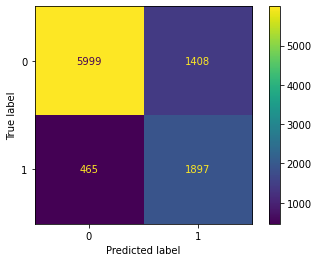

In [8]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.93      0.81      0.86      7407
        >50K       0.57      0.80      0.67      2362

    accuracy                           0.81      9769
   macro avg       0.75      0.81      0.77      9769
weighted avg       0.84      0.81      0.82      9769



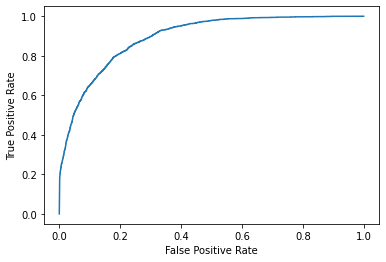

In [10]:
y_pred1 = gnb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred1, pos_label = ' >50K')
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

Przprowadź uczenie klasyfikatora dla kolumn *race* i *native_country*. Podaj dokładnosć modeli i macierze błędu wraz z ich wykresami i interpretacją. Przedstaw wnioski od czego zależą otrzymane wyniki

# Race

In [11]:
df = pd.read_csv('data.csv')

df.replace(' ?', np.NaN, inplace=True)

X = df.drop(['race'], axis=1)
y = df['race']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

for df2 in [X_train, X_test]:
    df2['workclass'].fillna(X_train['workclass'].mode()[0], inplace=True)
    df2['occupation'].fillna(X_train['occupation'].mode()[0], inplace=True)
    df2['native_country'].fillna(X_train['native_country'].mode()[0], inplace=True)

encoder = ce.OneHotEncoder(categorical)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

cols = X_train.columns
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_2 = pd.DataFrame(X_train, columns=[cols])
X_test_2 = pd.DataFrame(X_test, columns=[cols])

gnb = GaussianNB()
gnb.fit(X_train_2, y_train)
y_pred = gnb.predict(X_test_2)
print('Predykcja:\n{0}\n'.format(y_pred))

acc = accuracy_score(y_test, y_pred)
print('Model accuracy score: {0:0.4f}'. format(acc))

y_pred_train = gnb.predict(X_train)
acc_2 = accuracy_score(y_train, y_pred_train)
print('Training-set accuracy score: {0:0.4f}'. format(acc_2))

print('Training set score: {:.4f}'.format(gnb.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(gnb.score(X_test, y_test)))

c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteri

Predykcja:
[' Black' ' White' ' White' ... ' White' ' White' ' Black']

Model accuracy score: 0.6721
Training-set accuracy score: 0.6763
Training set score: 0.6763
Test set score: 0.6721


'Test set score' jest bardzo bliskie 'Training-set accuracy score' co świadczy o braku overfittingu. 

                     precision    recall  f1-score   support

 Amer-Indian-Eskimo       0.03      0.07      0.04        80
 Asian-Pac-Islander       0.74      0.51      0.61       318
              Black       0.18      0.52      0.27       911
              Other       0.08      0.29      0.12        72
              White       0.91      0.70      0.79      8388

           accuracy                           0.67      9769
          macro avg       0.39      0.42      0.37      9769
       weighted avg       0.82      0.67      0.73      9769



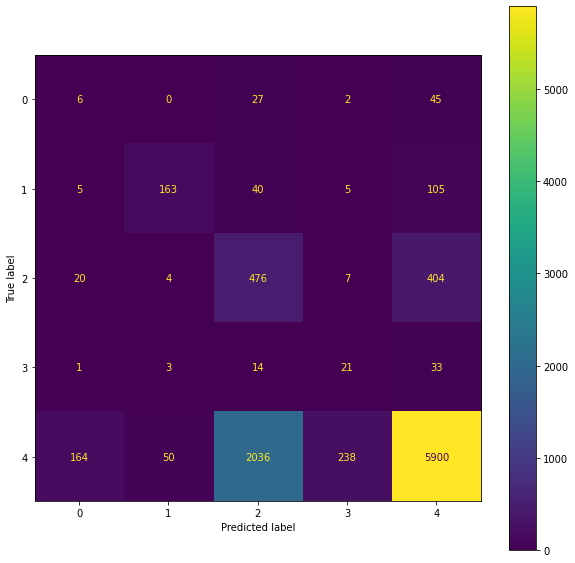

In [12]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10,10))
cm_display.plot(ax=ax)
print(classification_report(y_test, y_pred))

Dopasowanie modelu jest na poziomie 67,21%

# Native_country

In [13]:
df = pd.read_csv('data.csv')

df.replace(' ?', np.NaN, inplace=True)
df.dropna(subset=['native_country'], inplace=True)

X = df.drop(['native_country'], axis=1)
y = df['native_country']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']
numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

for df2 in [X_train, X_test]:
    df2['workclass'].fillna(X_train['workclass'].mode()[0], inplace=True)
    df2['occupation'].fillna(X_train['occupation'].mode()[0], inplace=True)

encoder = ce.OneHotEncoder(categorical)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

cols = X_train.columns
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_2 = pd.DataFrame(X_train, columns=[cols])
X_test_2 = pd.DataFrame(X_test, columns=[cols])

gnb = GaussianNB()
gnb.fit(X_train_2, y_train)
y_pred = gnb.predict(X_test_2)
print('Predykcja:\n{0}\n'.format(y_pred))

acc = accuracy_score(y_test, y_pred)
print('Model accuracy score: {0:0.4f}'. format(acc))

y_pred_train = gnb.predict(X_train)
acc_2 = accuracy_score(y_train, y_pred_train)
print('Training-set accuracy score: {0:0.4f}'. format(acc_2))

print('Training set score: {:.4f}'.format(gnb.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(gnb.score(X_test, y_test)))

c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteri

Predykcja:
[' Outlying-US(Guam-USVI-etc)' ' Greece' ' Guatemala' ... ' Peru'
 ' Yugoslavia' ' Yugoslavia']

Model accuracy score: 0.0315
Training-set accuracy score: 0.0343
Training set score: 0.0343
Test set score: 0.0315


'Test set score' jest bardzo bliskie 'Training-set accuracy score' co świadczy o braku overfittingu. 

c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\szyme\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

                             precision    recall  f1-score   support

                   Cambodia       0.00      0.00      0.00         4
                     Canada       0.00      0.00      0.00        33
                      China       0.67      0.08      0.14        26
                   Columbia       0.00      0.00      0.00        22
                       Cuba       0.00      0.00      0.00        33
         Dominican-Republic       0.00      0.00      0.00        17
                    Ecuador       0.02      0.40      0.03         5
                El-Salvador       0.00      0.00      0.00        24
                    England       0.00      0.00      0.00        32
                     France       0.00      0.11      0.01         9
                    Germany       0.00      0.00      0.00        45
                     Greece       0.00      0.00      0.00         8
                  Guatemala       0.05      0.35      0.09        17
                      Haiti      

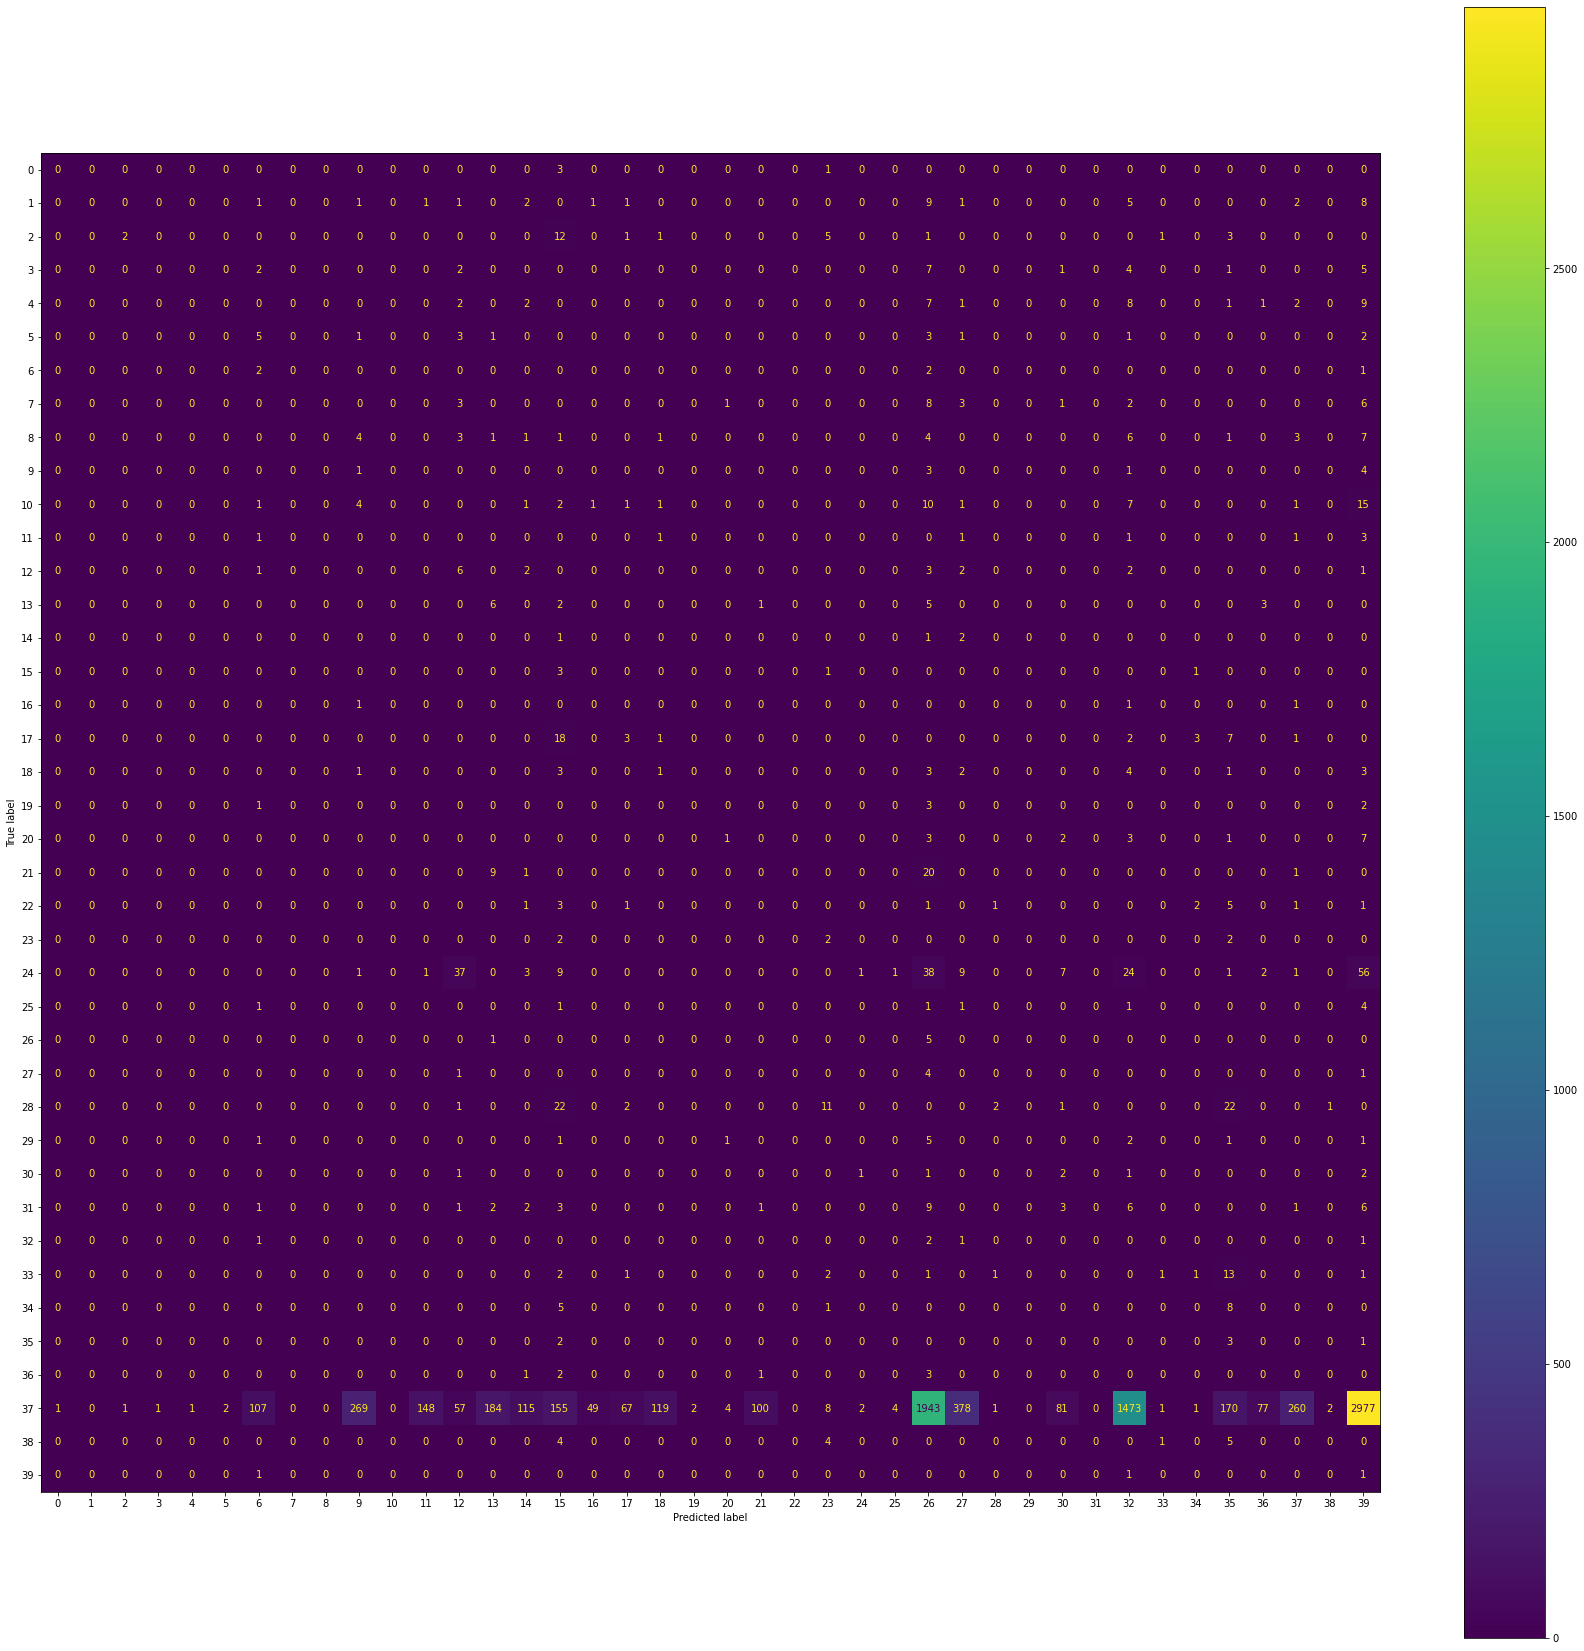

In [14]:
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(30,30))
cm_display.plot(ax=ax)
print(classification_report(y_test, y_pred))

Dopasowanie modelu jest na poziomie 3%. 

Jak widać po powyższych wynikach, na jakość wyników maleje wraz z wzrostem ilości unikalnych danych w kolumnach. Dla pierwszego przypadku dla dwóch unikalnych danych dopasowanie było najlepsze. Dla drugiego przypadku, gdy danych unikalnych było więcej dopasowanie wyniosło 67% co i tak jest dosyć dobrym wynikiem. W ostatnim przypadku dopasowanie wyniosło około 3%. Wynika to z faktu, że było bardzo dużo unikalnych danych w kolumnie.